In [51]:
%load_ext autoreload
%autoreload 2

from architecture import GMMVAE
from my_loss import GMMVAE_loss
import torch

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split

import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
SEED = 12

In [53]:
N, M, L, K = 1024, 200, 10, 7
RNA_seq = torch.randint(low=0, high=1000, size=(N, M), dtype=torch.float)

In [54]:
Xtrain, Xtest = train_test_split(RNA_seq, train_size=0.5, random_state=SEED)

Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
Xtest = torch.tensor(Xtest, dtype=torch.float32)

batch_size = 32

dataset_train = torch.utils.data.TensorDataset(Xtrain)
dataset_test = torch.utils.data.TensorDataset(Xtest)


dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=False)

C:\Users\33699\AppData\Local\Temp\ipykernel_16224\4002638573.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
C:\Users\33699\AppData\Local\Temp\ipykernel_16224\4002638573.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtest = torch.tensor(Xtest, dtype=torch.float32)


In [55]:
prior_zGy_mu, prior_zGy_var , prior_y = torch.zeros(size=(K, L)), torch.ones(size=(K, L)), torch.log_softmax(torch.ones(size=(K,))/K, dim=0)
gamma_zGy, gamma_y = 0, 0

In [56]:
NN = GMMVAE(N=batch_size, M=M, L=L, K=K, x_law="ZIP")

In [57]:
criterion = GMMVAE_loss(prior_zGy_mu, prior_zGy_var, prior_y, gamma_zGy, gamma_y, "ZIP")

In [58]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)

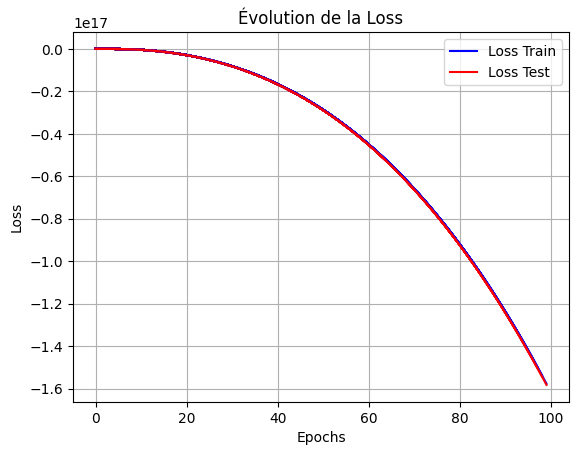

100%|██████████| 1000/1000 [02:04<00:00,  8.00it/s]


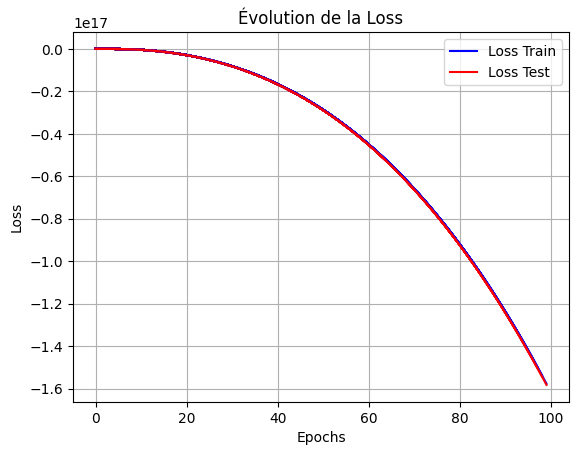

In [59]:
num_epochs = 1000
loss_train, loss_test = [], []

plt.figure()

c = 0

for epoch in tqdm.tqdm(range(num_epochs)):
    epoch_loss_train = 0.0
    epoch_loss_test = 0.0
    
    for batch in dataloader_train:
        x_parameters, MUs, VARs, z, PIs = NN(batch[0][None, :, :])
        loss = criterion(batch[0][None, :, :], x_parameters, MUs, VARs, PIs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss_train += loss.item()

    if c % 10 == 0:
        for batch in dataloader_test:
            x_parameters, MUs, VARs, z, PIs = NN(batch[0][None, :, :])
            loss = criterion(batch[0][None, :, :], x_parameters, MUs, VARs, PIs)
            epoch_loss_test += loss.item()

        loss_train.append(epoch_loss_train / len(dataloader_train))
        loss_test.append(epoch_loss_test / len(dataloader_test))

        clear_output(wait=True)
        plt.plot(loss_train, label="Loss Train", color="blue")
        plt.plot(loss_test, label="Loss Test", color="red")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Évolution de la Loss")
        if c == 0:
            plt.legend()
            plt.grid()
        display(plt.gcf())

    c += 1


plt.show()